In [ ]:
# default_exp inferno_interp

In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# Interpolation INFERNO loss

Attempted reproduction INFERNO following paper description implementations with nuisances being approximated by creating up/down shapes and interpolating
Runs and reproduces some of the paper results

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
from pytorch_inferno.callback import AbsCallback, PredHandler

import numpy as np
from abc import abstractmethod
from typing import Tuple, Optional

import torch.nn as nn
from torch import Tensor

In [ ]:
from pytorch_inferno.model_wrapper import ModelWrapper
from pytorch_inferno.callback import *
from pytorch_inferno.data import get_paper_data
from pytorch_inferno.plotting import *
from pytorch_inferno.inference import *
from pytorch_inferno.utils import *

from fastcore.all import partialler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from typing import *
from collections import OrderedDict
from fastcore.all import store_attr

import torch.nn.functional as F
from torch import optim, autograd
import torch
from torch.distributions import Normal

# Network

In [ ]:
bs = 2000
data, test = get_paper_data(200000, bs=bs, n_test=1000000)

In [ ]:
# export
class VariableSoftmax(nn.Softmax):
    r'''Softmax with temperature'''
    def __init__(self, temp:float=1, dim:int=-1):
        super().__init__(dim=dim)
        self.temp = temp
        
    def forward(self, x:Tensor) -> Tensor: return super().forward(x/self.temp)

In [ ]:
x = torch.randn((1,10))

In [ ]:
VariableSoftmax(0.1)(x), VariableSoftmax(0.5)(x), VariableSoftmax(1)(x)

(tensor([[2.5764e-05, 9.8668e-01, 6.9278e-05, 2.8337e-07, 5.1690e-06, 1.8804e-08,
          2.0606e-05, 3.1019e-03, 9.5631e-03, 5.3575e-04]]),
 tensor([[0.0488, 0.4026, 0.0594, 0.0198, 0.0354, 0.0115, 0.0466, 0.1272, 0.1593,
          0.0895]]),
 tensor([[0.0787, 0.2261, 0.0869, 0.0501, 0.0670, 0.0382, 0.0770, 0.1271, 0.1422,
          0.1066]]))

In [ ]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)

# Loss

In [ ]:
x,y,w = next(iter(data.trn_dl))
preds = net(x)
assert preds.shape == (bs,10)

In [ ]:
def to_shape(p:Tensor) -> Tensor:
    f = p.sum(0)
    f = f/f.sum()
    return f

In [ ]:
m = y.squeeze()==0
f_s = to_shape(preds[~m])
f_b = to_shape(preds[m])

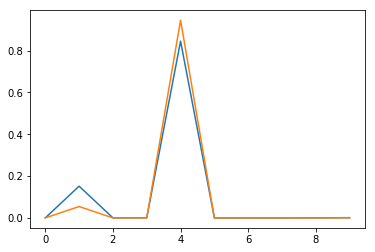

In [ ]:
plt.plot(to_np(f_s))
plt.plot(to_np(f_b))

## Minimise width

with torch.no_grad():
    u,d = [],[]
    b = x[m]
    b[:,0] += 0.2
    u.append(to_shape(net(b)))
    b[:,0] -= 0.2
    b[:,2] *= 3.5/3
    u.append(to_shape(net(b)))
    b[:,2] /= 3.5/3
    b[:,0] -= 0.2
    d.append(to_shape(net(b)))
    b[:,0] += 0.2
    b[:,2] *= 2.5/3
    d.append(to_shape(net(b)))
    b[:,2] /= 2.5/3
    b_up,b_dw = torch.stack(u),torch.stack(d)

nll,alpha = calc_profile(f_s=f_s, f_b_nom=f_b, f_b_up=b_up, f_b_dw=b_dw, verbose=False, n=1050, mu_scan=torch.linspace(20,80,61), true_mu=50)

nll

plot_likelihood(to_np(nll-nll[nll==nll].min()))

nll = nll-nll[nll==nll].min()-0.5

nll

plot_likelihood(to_np(nll))

nll.max()-nll.min()

def get_diff_width(nll:Tensor, mu_scan:np.ndarray) -> Tensor:
    def lin_root(nll0,nll1,mu0,mu1):
        a = (nll1-nll0)/(mu1-mu0)
        b = nll1-(a*mu1)
        return -b/a
    
    u,r,last_mu,last_nll = True,torch.zeros((2)),mu_scan[0],nll[0]

    for mu,l in zip(mu_scan[1:],nll[1:]):
        if u and l < 0:
            r[0] = lin_root(last_nll,l,last_mu,mu)
            u = False
        elif not u and l > 0:
            r[1] = lin_root(last_nll,l,last_mu,mu)
            break
        if l == l: last_mu,last_nll = mu,l
    return r[1]-r[0]

w = get_diff_width(nll, mu_scan=np.linspace(20,80,61)); w

class AbsInferno(AbsCallback):
    def __init__(self, n:int, mu_scan:Tensor, true_mu:int, n_steps:int=100, lr:float=0.1):
        super().__init__()
        store_attr()
        
    def on_train_begin(self) -> None:
        r'''
        Fake loss function, callback computes loss in `on_forwards_end`
        '''
        self.wrapper.loss_func = lambda x,y: None
        self.profiler = partialler(calc_profile, n=self.n, mu_scan=to_device(self.mu_scan, self.wrapper.device), true_mu=self.true_mu,
                                   n_steps=self.n_steps, lr=self.lr, verbose=False)
        
    @staticmethod
    def _to_shape(p:Tensor) -> Tensor:
        f = p.sum(0)
        f = f + 1e-7
        f = f/f.sum()
        return f
    
    @abstractmethod
    def _get_up_down(self, x:Tensor) -> Tuple[Tensor,Tensor]: pass
        
    def _get_diff_width(self, nll:Tensor) -> Tensor:
        def lin_root(nll0,nll1,mu0,mu1):
            a = (nll1-nll0)/(mu1-mu0)
            b = nll1-(a*mu1)
            return -b/a

        u,r,last_mu,last_nll = True,torch.zeros((2)),self.mu_scan[0],nll[0]
        for mu,l in zip(self.mu_scan[1:],nll[1:]):
            if u and l < 0:
                r[0] = lin_root(last_nll,l,last_mu,mu)
                u = False
            elif not u and l > 0:
                r[1] = lin_root(last_nll,l,last_mu,mu)
                break
            if l == l: last_mu,last_nll = mu,l
        return r[1]-r[0]
        
    def on_forwards_end(self) -> None:
        # Get sig. & bkg. shapes
        b = self.wrapper.y.squeeze()==0
        f_s = self._to_shape(self.wrapper.y_pred[~b])
        f_b = self._to_shape(self.wrapper.y_pred[b])
        f_b_up,f_b_dw = self._get_up_down(self.wrapper.x[b])
        
        # Compute nll
        nll,_ = self.profiler(f_s=f_s, f_b_nom=f_b, f_b_up=f_b_up, f_b_dw=f_b_dw)
        try: nll = nll-nll[nll==nll].min()-0.5
        except RuntimeError: print(nll, self.wrapper.y_pred)
        w = self._get_diff_width(nll)
        print(w)
        print(self.wrapper.model[4].weight)
        self.wrapper.loss_val = torch.clamp_min(w, 0)

class PaperInferno(AbsInferno):
    def __init__(self, n:int=1050, mu_scan:Tensor=torch.linspace(20,80,61), true_mu:int=50, n_steps:int=100, lr:float=0.1):
        super().__init__(n=n, mu_scan=mu_scan, true_mu=true_mu, n_steps=n_steps, lr=lr)
    
    def _get_up_down(self, x:Tensor) -> Tuple[Tensor,Tensor]:
        with torch.no_grad():
            u,d = [],[]
            x[:,0] += 0.2
            u.append(self._to_shape(self.wrapper.model(x)))
            x[:,0] -= 0.2
            x[:,2] *= 3.5/3
            u.append(self._to_shape(self.wrapper.model(x)))
            x[:,2] /= 3.5/3
            x[:,0] -= 0.2
            d.append(self._to_shape(self.wrapper.model(x)))
            x[:,0] += 0.2
            x[:,2] *= 2.5/3
            d.append(self._to_shape(self.wrapper.model(x)))
            x[:,2] /= 2.5/3
            return torch.stack(u),torch.stack(d)

net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)
model = ModelWrapper(net)
model.fit(200, data=data, opt=partialler(optim.SGD,lr=1e-6), loss=nn.BCELoss(),
          cbs=[PaperInferno(),LossTracker(),EarlyStopping(5),GradClip(1e-5)])

model.save('weights/Inferno_Test.h5')

Class initialised with a true number of signal events $\mu$ and a true number of events $n$. The true number of background events is then computed as $n-mu$. The number of nuisance parameters must also be passed.

This process only approximates the effect of shape systematics, since they are evaluated as up/down shape variations and the inter-dependence of them is not accounted for. It is, however, perhaps more realistic/practical, since the exact effect of the nuisances on the input features do not have to be analytically derivable, instead one can use up/down Monte Carlo samples. For this synthetic example, the analytical effects are used.

Running cycle is:
1. for e in #epochs:
    1. for b in #batches:
        1. on_forwards_end:
            1. compute up/down shape variations by augmenting data and passing through model
            1. set alpha as tensor with gradient and `n_alpha+1` elements. Set element zero to $\mu$
            1. compute the full hessian of the negative log-likelihood w.r.t alpha (shape systematics included by running model augmented data to get up/down shapes)
            1. invert hessian and set the diagonal element corresponding to $\mu$ as the loss value

In [ ]:
# export
class AbsInferno(AbsCallback):
    r'''Attempted reproduction INFERNO following paper description implementations with nuisances being approximated by creating up/down shapes and interpolating
    Runs and reproduces some of the paper results
    Includes option to randomise params per batch and converge to better values, but results in slightly worse performance'''
    def __init__(self, n:int, true_mu:float, aug_alpha:bool=False, n_alphas:int=0, n_steps:int=100, lr:float=0.1):
        super().__init__()
        store_attr()
        self.true_b = self.n-self.true_mu
        
    def on_train_begin(self) -> None:
        self.wrapper.loss_func = None  # Ensure loss function is skipped, callback computes loss value in `on_forwards_end`
        for c in self.wrapper.cbs:
            if hasattr(c, 'loss_is_meaned'): c.loss_is_meaned = False  # Ensure that average losses are correct
    
    @staticmethod
    def to_shape(p:Tensor) -> Tensor:
        f = p.sum(0)+1e-7
        return f/f.sum()
        
    @abstractmethod
    def _get_up_down(self, x:Tensor) -> Tuple[Tensor,Tensor]:
        r'''Compute upd/down shapes. Overide this for specific problem.'''
        pass
    
    def get_ikk(self, f_s:Tensor, f_b_nom:Tensor, f_b_up:Tensor, f_b_dw:Tensor) -> Tensor:
        r'''Compute full hessian at true param values, or at random starting values with Newton updates'''
        if self.aug_alpha: alpha = torch.randn((self.n_alphas+1), requires_grad=True, device=self.wrapper.device)/10
        else:              alpha = torch.zeros((self.n_alphas+1), requires_grad=True, device=self.wrapper.device)
        with torch.no_grad(): alpha[0] += self.true_mu
        get_nll = partialler(calc_nll, s_true=self.true_mu, b_true=self.true_b,
                             f_s=f_s, f_b_nom=f_b_nom, f_b_up=f_b_up, f_b_dw=f_b_dw)
        if self.aug_alpha:  # Alphas carry noise, optimise via Newton
            for i in range(self.n_steps):  # Newton optimise nuisances & mu
                nll = get_nll(s_exp=alpha[0], alpha=alpha[1:])
                g,h = calc_grad_hesse(nll, alpha)
                s = torch.clamp(self.lr*g.detach()@torch.inverse(h), -100, 100)
                alpha = alpha-s
        nll = get_nll(s_exp=alpha[0], alpha=alpha[1:])
        _,h = calc_grad_hesse(nll, alpha, create_graph=True)
#         print('hess', h)
#         print('inverse', torch.inverse(h))
#         print('reciprocal', 1/h)
        return torch.inverse(h)[0,0]
        
    def on_forwards_end(self) -> None:
        r'''Compute loss and replace wrapper loss value'''
        b = self.wrapper.y.squeeze() == 0
        f_s = to_shape(self.wrapper.y_pred[~b])
        f_b = to_shape(self.wrapper.y_pred[b])
        f_b_up,f_b_dw = self._get_up_down(self.wrapper.x[b])
        self.wrapper.loss_val = self.get_ikk(f_s=f_s, f_b_nom=f_b, f_b_up=f_b_up, f_b_dw=f_b_dw)

In [ ]:
# export
class PaperInferno(AbsInferno):
    def __init__(self, r_mods:Optional[Tuple[float,float]]=(-0.2,0.2), l_mods:Optional[Tuple[float,float]]=(2.5,3.5), l_init:float=3,
                 n:int=1050, true_mu:int=50, aug_alpha:bool=False, n_steps:int=10, lr:float=0.1):
        r'''Inheriting class for dealing with INFERNO paper synthetic problem'''
        super().__init__(n=n, true_mu=true_mu, aug_alpha=aug_alpha, n_alphas=(r_mods is not None)+(l_mods is not None), n_steps=n_steps, lr=lr)
        self.r_mods,self.l_mods,self.l_init = r_mods,l_mods,l_init
        
    def on_train_begin(self) -> None:
        if self.r_mods is not None:
            self.r_mod_t = (torch.zeros(1,3, device=self.wrapper.device),torch.zeros(1,3, device=self.wrapper.device))
            self.r_mod_t[0][0,0] = self.r_mods[0]
            self.r_mod_t[1][0,0] = self.r_mods[1]
        if self.l_mods is not None:
            self.l_mod_t = (torch.ones(1,3, device=self.wrapper.device),torch.ones(1,3, device=self.wrapper.device))
            self.l_mod_t[0][0,2] = self.l_mods[0]/self.l_init
            self.l_mod_t[1][0,2] = self.l_mods[1]/self.l_init
    
    def _get_up_down(self, x:Tensor) -> Tuple[Tensor,Tensor]:
        if self.r_mods is None and self.l_mods is None: return None,None
        u,d = [],[]
        if self.r_mods is not None:
            x = x+self.r_mod_t[0]
            d.append(self.to_shape(self.wrapper.model(x)))
            x = x+self.r_mod_t[1]-self.r_mod_t[0]
            u.append(self.to_shape(self.wrapper.model(x)))
            x = x-self.r_mod_t[1]
        if self.l_mods is not None:
            x = x*self.l_mod_t[0]
            d.append(self.to_shape(self.wrapper.model(x)))
            x = x*self.l_mod_t[1]/self.l_mod_t[0]
            u.append(self.to_shape(self.wrapper.model(x)))
            x = x/self.l_mod_t[1]
        return torch.stack(u),torch.stack(d)

In [ ]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)
model = ModelWrapper(net)

In [ ]:
%%time
model.fit(200, data=data, opt=partialler(optim.SGD,lr=1e-6), loss=None,
          cbs=[PaperInferno(aug_alpha=False, n_steps=10),LossTracker(),SaveBest('weights/best_ii.h5'),EarlyStopping(10)])

1: Train=584.8180621337891 Valid=547.0645452880859
2: Train=504.9815756225586 Valid=474.89647521972654
3: Train=444.99858032226564 Valid=434.3520794677734
4: Train=418.09558166503905 Valid=412.1406610107422
5: Train=399.3894039916992 Valid=396.6260430908203
6: Train=385.81950225830076 Valid=382.5768389892578
7: Train=374.41923828125 Valid=375.5198193359375
8: Train=366.83497009277346 Valid=365.0942498779297
9: Train=359.8556225585937 Valid=360.1676373291016
10: Train=353.44849670410156 Valid=353.5235107421875
11: Train=349.110849609375 Valid=348.69276733398436
12: Train=344.82844177246096 Valid=345.64845153808596
13: Train=341.80301971435546 Valid=342.19988525390625
14: Train=339.12335083007815 Valid=339.48112243652344
15: Train=337.2709732055664 Valid=337.83915771484374
16: Train=335.1123620605469 Valid=335.8587127685547
17: Train=332.78798919677735 Valid=334.58326171875
18: Train=331.8588854980469 Valid=333.99626220703124
19: Train=330.73973052978516 Valid=332.6272686767578
20: Train

156: Train=303.530323638916 Valid=310.0196221923828
157: Train=303.5805548095703 Valid=310.45058288574216
158: Train=303.63150039672854 Valid=309.66918518066404
159: Train=303.2544752502441 Valid=310.03730712890626
160: Train=303.3519053649902 Valid=308.7639733886719
161: Train=302.94400924682617 Valid=309.5708117675781
162: Train=303.1213432312012 Valid=308.6613708496094
163: Train=303.692568359375 Valid=309.4315246582031
164: Train=302.9604344177246 Valid=309.2334307861328
165: Train=302.01986068725586 Valid=308.4704254150391
166: Train=302.45460388183596 Valid=307.78952941894534
167: Train=302.12265838623046 Valid=307.82814453125
168: Train=301.7675784301758 Valid=306.6632855224609
169: Train=300.61818634033204 Valid=304.78937255859375
170: Train=299.36311935424806 Valid=304.88407653808594
171: Train=298.0310551452637 Valid=302.9767193603516
172: Train=297.12161483764646 Valid=302.4904913330078
173: Train=295.93269439697264 Valid=300.13297973632814
174: Train=294.8458912658691 Valid

In [ ]:
model.save('weights/Inferno_Test_interp_bm2.h5')

In [ ]:
model.load('weights/Inferno_Test_interp_bm2.h5')

# Results

In [ ]:
# export
class InfernoPred(PredHandler):
    r'''Prediction handler for hard assignments'''
    def get_preds(self) -> np.ndarray: return np.argmax(self.preds, 1)

## BM 0

In [ ]:
preds = model._predict_dl(test, pred_cb=InfernoPred())

In [ ]:
df = pd.DataFrame({'pred':preds})
df['gen_target'] = test.dataset.y
df.head()

,pred,gen_target
0,6,1.0
1,2,1.0
2,6,1.0
3,9,1.0
4,1,1.0


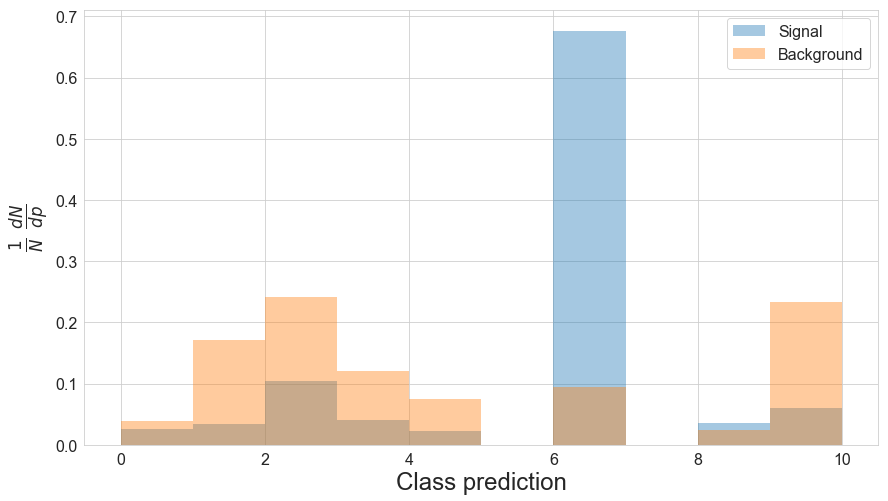

In [ ]:
plot_preds(df, bin_edges=np.linspace(0,10,11))

In [ ]:
bin_preds(df)

In [ ]:
df.head()

,pred,gen_target,pred_bin
0,3,1.0,3
1,3,1.0,3
2,3,1.0,3
3,3,1.0,3
4,2,1.0,2


In [ ]:
f_s,f_b = get_shape(df,1),get_shape(df,0)

In [ ]:
f_s.sum(), f_b.sum()

(tensor(1.), tensor(1.))

In [ ]:
f_s, f_b

(tensor([9.3754e-02, 1.1604e-02, 9.2810e-02, 5.3080e-01, 1.9031e-01, 5.6652e-02,
         4.7120e-03, 1.9360e-02, 2.0000e-13, 2.0000e-13]),
 tensor([3.9630e-01, 1.1812e-02, 3.5878e-01, 6.2556e-02, 4.9080e-02, 5.7156e-02,
         5.8780e-03, 5.8436e-02, 2.0000e-13, 2.0000e-13]))

In [ ]:
asimov = (50*f_s)+(1000*f_b)

In [ ]:
asimov, asimov.sum()

(tensor([4.0099e+02, 1.2392e+01, 3.6342e+02, 8.9096e+01, 5.8595e+01, 5.9989e+01,
         6.1136e+00, 5.9404e+01, 2.1000e-10, 2.1000e-10]), tensor(1050.))

In [ ]:
n = 1050
x = np.linspace(20,80,61)
y = np.zeros_like(x)
for i,m in enumerate(x):
    pois = torch.distributions.Poisson((m*f_s)+(1000*f_b))
    y[i] = -pois.log_prob(asimov).sum()
y

array([25.82702255, 25.68968201, 25.55858421, 25.43251801, 25.31179428,
       25.19625854, 25.08618164, 24.9810524 , 24.88123322, 24.78644943,
       24.69649887, 24.6111908 , 24.53120613, 24.45590401, 24.38507462,
       24.31925011, 24.25819969, 24.2009964 , 24.14891624, 24.10118675,
       24.05751419, 24.01886177, 23.98382759, 23.95327377, 23.92707062,
       23.9053421 , 23.88687515, 23.87307358, 23.8629818 , 23.85758591,
       23.85538292, 23.85734558, 23.8631649 , 23.87264633, 23.88638306,
       23.90337181, 23.92403793, 23.9485569 , 23.97665024, 24.00831223,
       24.04363441, 24.08237457, 24.12467194, 24.17042732, 24.21935654,
       24.27204132, 24.32791138, 24.38698578, 24.44943047, 24.51529312,
       24.58412552, 24.65593338, 24.73155785, 24.80966759, 24.89127159,
       24.97566414, 25.06313705, 25.15376854, 25.24755478, 25.34410477,
       25.44344711])

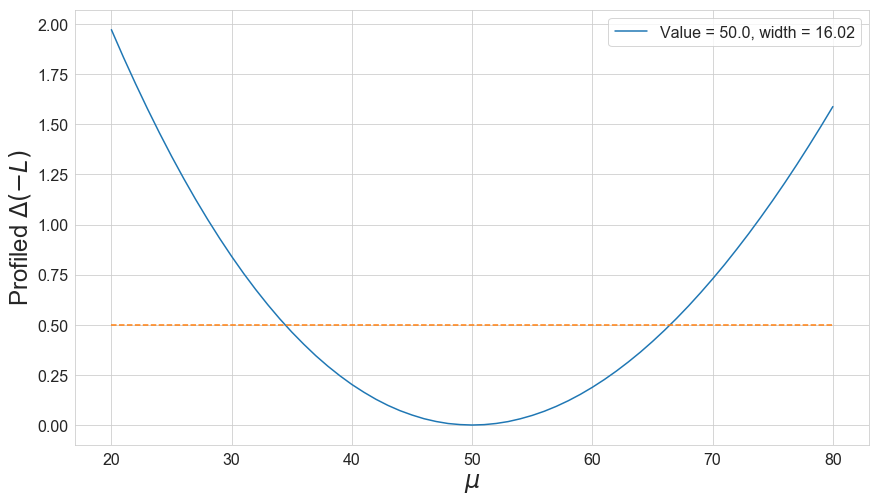

In [ ]:
plot_likelihood(y-y.min())

# Nuisances - via interpolation

In [ ]:
bkg = test.dataset.x[test.dataset.y.squeeze() == 0]
assert len(bkg) == 500000

In [ ]:
b_shapes = get_paper_syst_shapes(bkg, df, model=model, pred_cb=InfernoPred())

Running: r=-0.2


Running: r=0


Running: r=0.2


Running: l=2.5


Running: l=3


Running: l=3.5


In [ ]:
df

,pred,gen_target,pred_bin,pred_-0.2_3,pred_-0.2_3_bin,pred_0_3,pred_0_3_bin,pred_0.2_3,pred_0.2_3_bin,pred_0_2.5,pred_0_2.5_bin,pred_0_3.5,pred_0_3.5_bin
0,3,1.0,3,3,3,3,3,3,3,3,3,3,3
1,3,1.0,3,3,3,3,3,3,3,3,3,3,3
2,3,1.0,3,3,3,3,3,3,3,3,3,3,3
3,3,1.0,3,3,3,3,3,3,3,3,3,3,3
4,2,1.0,2,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,4,0.0,4,4,4,4,4,4,4,4,4,4,4
999996,0,0.0,0,0,0,0,0,0,0,0,0,0,0
999997,2,0.0,2,0,0,2,2,2,2,2,2,0,0
999998,0,0.0,0,0,0,0,0,0,0,0,0,0,0


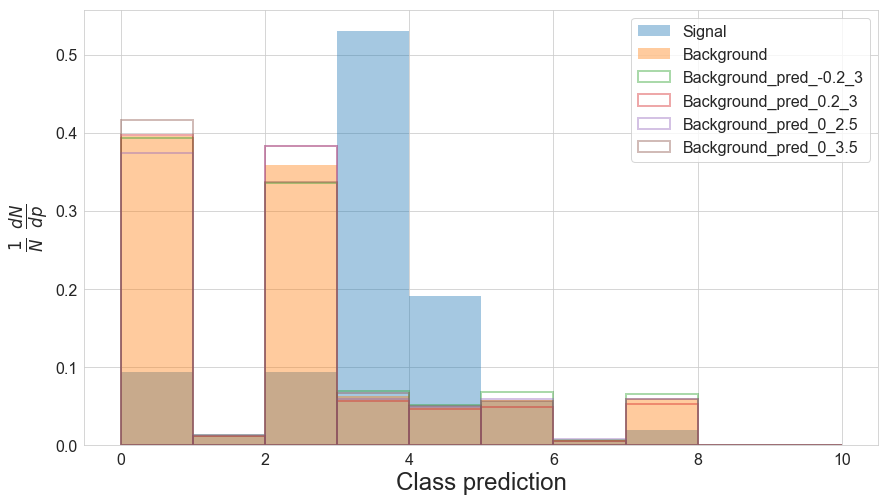

In [ ]:
plot_preds(df, pred_names=['pred', 'pred_-0.2_3', 'pred_0.2_3', 'pred_0_2.5', 'pred_0_3.5'], bin_edges=np.linspace(0,10,11))

tensor([3.7129e-01, 1.3446e-02, 3.5888e-01, 6.4948e-02, 5.0556e-02, 6.8570e-02,
        7.2840e-03, 6.5018e-02, 2.0000e-13, 2.0000e-13])
tensor([3.9352e-01, 1.2362e-02, 3.3509e-01, 6.8942e-02, 5.1254e-02, 6.7430e-02,
        6.2480e-03, 6.5154e-02, 2.0000e-13, 2.0000e-13])
tensor([4.1382e-01, 1.1308e-02, 3.1321e-01, 7.3302e-02, 5.1286e-02, 6.6346e-02,
        5.5160e-03, 6.5216e-02, 2.0000e-13, 2.0000e-13])
tensor([3.7407e-01, 1.2896e-02, 3.8258e-01, 5.8562e-02, 4.8382e-02, 5.8296e-02,
        6.9140e-03, 5.8300e-02, 2.0000e-13, 2.0000e-13])
tensor([3.9630e-01, 1.1812e-02, 3.5878e-01, 6.2556e-02, 4.9080e-02, 5.7156e-02,
        5.8780e-03, 5.8436e-02, 2.0000e-13, 2.0000e-13])
tensor([4.1660e-01, 1.0758e-02, 3.3690e-01, 6.6916e-02, 4.9112e-02, 5.6072e-02,
        5.1460e-03, 5.8498e-02, 2.0000e-13, 2.0000e-13])
tensor([3.7480e-01, 1.1820e-02, 4.0717e-01, 5.2726e-02, 4.5580e-02, 4.9578e-02,
        6.5200e-03, 5.1798e-02, 2.0000e-13, 2.0000e-13])
tensor([3.9703e-01, 1.0736e-02, 3.8338e-0

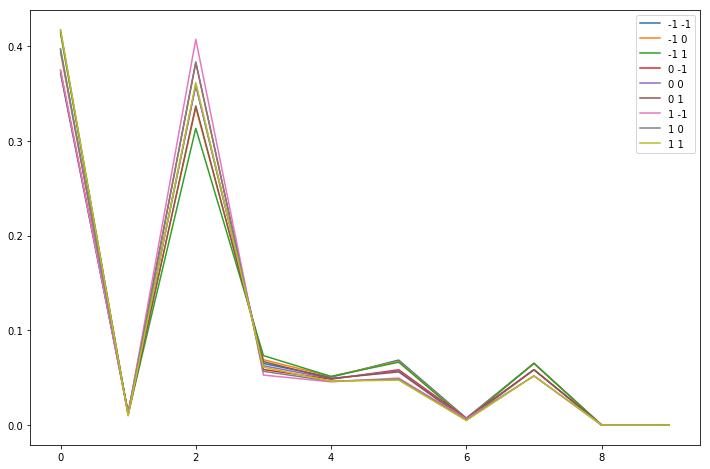

In [ ]:
fig = plt.figure(figsize=(12,8))
for r in [-1,0,1]:
    for l in [-1,0,1]:
        alpha = Tensor((r,l))[None,:]
        s = interp_shape(alpha, **b_shapes).squeeze()
        print(s)
        plt.plot(s, label=f'{r} {l}')
plt.legend()

# Newton

In [ ]:
profiler = partialler(calc_profile, n=1050, mu_scan=torch.linspace(20,80,61), true_mu=50)

## BM 1
r free, l fixed

In [ ]:
bm1_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                            ('f_b_up',  b_shapes['f_b_up'][0][None,:]),
                            ('f_b_dw',  b_shapes['f_b_dw'][0][None,:])])

In [ ]:
bm1_b_shapes['f_b_up'].shape

torch.Size([1, 10])

In [ ]:
nll = profiler(f_s=f_s, n_steps=100, **bm1_b_shapes)

In [ ]:
nll = to_np(nll)

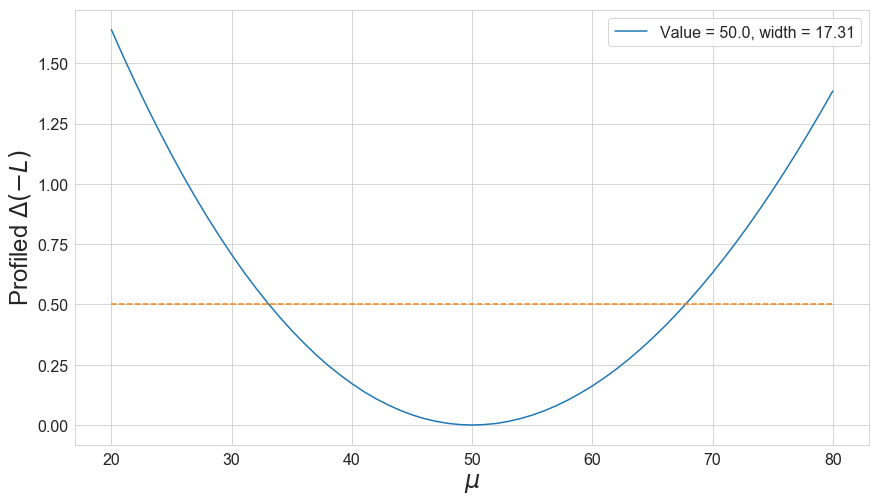

In [ ]:
plot_likelihood(nll-nll.min())

## BM 1l
r fixed, l free

In [ ]:
bm1l_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                             ('f_b_up',  b_shapes['f_b_up'][1][None,:]),
                             ('f_b_dw',  b_shapes['f_b_dw'][1][None,:])])

In [ ]:
nll = profiler(f_s=f_s, n_steps=100, **bm1l_b_shapes)

In [ ]:
nll = to_np(nll)

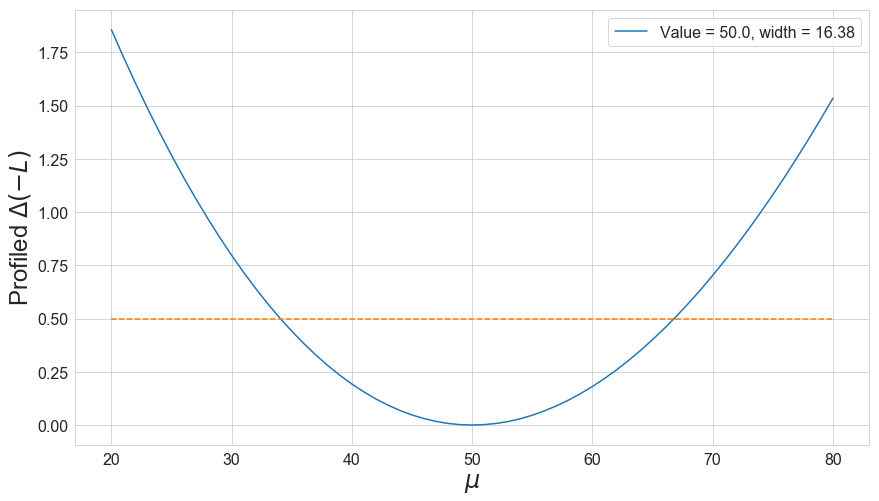

In [ ]:
plot_likelihood(nll-nll.min())

## BM 2

In [ ]:
nll = profiler(f_s=f_s, n_steps=100, **b_shapes)

In [ ]:
nll = to_np(nll)

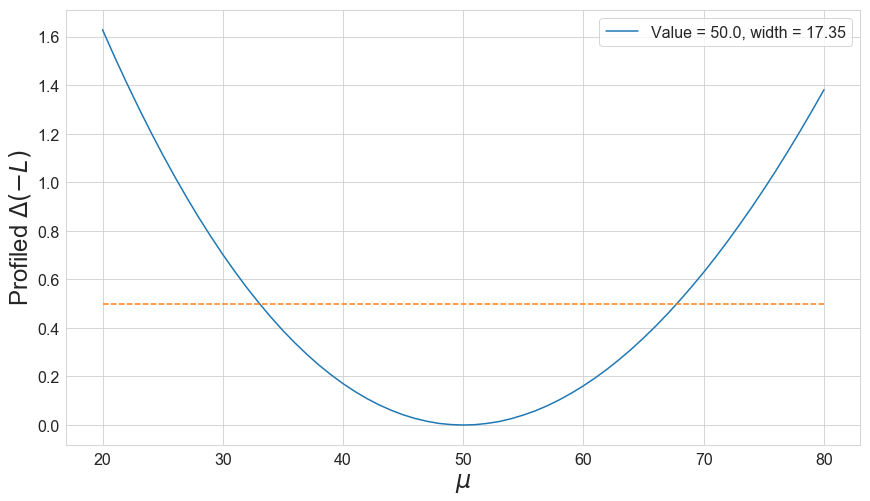

In [ ]:
plot_likelihood(nll-nll.min())

## BM 3

In [ ]:
alpha_aux = [Normal(0,2), Normal(0,2)]

In [ ]:
nll = profiler(f_s=f_s, n_steps=100, alpha_aux=alpha_aux, **b_shapes)

In [ ]:
nll = to_np(nll)

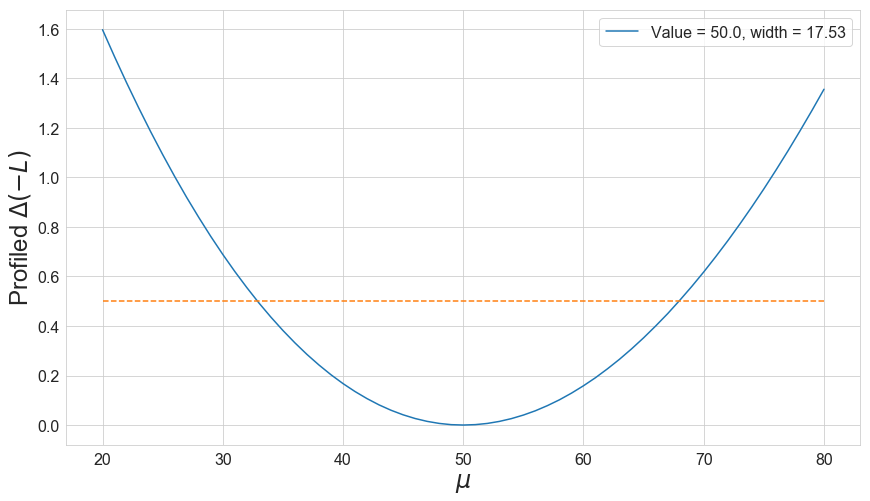

In [ ]:
plot_likelihood(nll-nll.min())

## BM 4

In [ ]:
alpha_aux = [Normal(0,2), Normal(0,2)]

In [ ]:
nll = profiler(f_s=f_s, n_steps=100, alpha_aux=alpha_aux, float_b=True, b_aux=Normal(1000,100), **b_shapes)

Linear regime: Mu 20.0, alpha tensor([-0.3123,  0.0630, 25.6584])
Linear regime: Mu 21.0, alpha tensor([-0.3013,  0.0605, 24.7352])
Linear regime: Mu 22.0, alpha tensor([-0.2903,  0.0580, 23.8171])
Linear regime: Mu 23.0, alpha tensor([-0.2794,  0.0556, 22.9040])
Linear regime: Mu 24.0, alpha tensor([-0.2685,  0.0531, 21.9960])
Linear regime: Mu 25.0, alpha tensor([-0.2576,  0.0507, 21.0929])
Linear regime: Mu 26.0, alpha tensor([-0.2468,  0.0484, 20.1947])
Linear regime: Mu 27.0, alpha tensor([-0.2361,  0.0460, 19.3014])
Linear regime: Mu 28.0, alpha tensor([-0.2253,  0.0437, 18.4129])
Linear regime: Mu 29.0, alpha tensor([-0.2147,  0.0414, 17.5292])
Linear regime: Mu 30.0, alpha tensor([-0.2040,  0.0392, 16.6502])
Linear regime: Mu 31.0, alpha tensor([-0.1935,  0.0370, 15.7760])
Linear regime: Mu 32.0, alpha tensor([-0.1829,  0.0348, 14.9063])
Linear regime: Mu 33.0, alpha tensor([-0.1724,  0.0326, 14.0413])
Linear regime: Mu 34.0, alpha tensor([-0.1619,  0.0305, 13.1809])
Linear reg

In [ ]:
nll = to_np(nll)

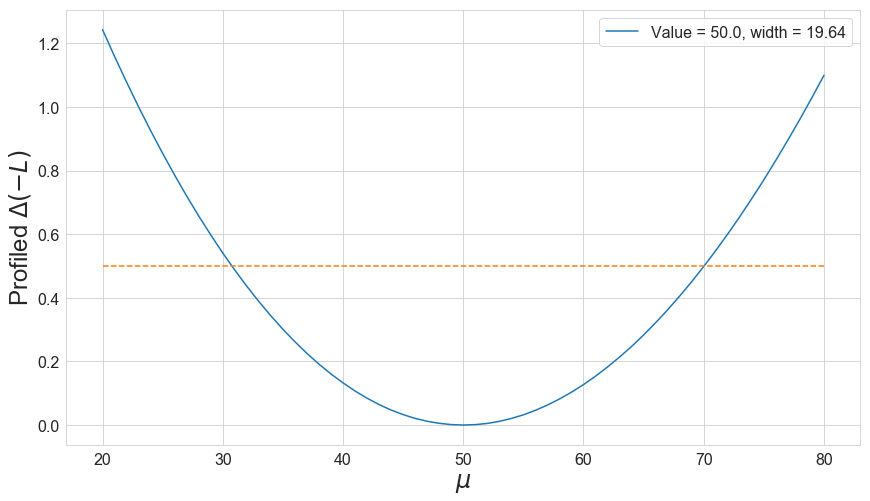

In [ ]:
plot_likelihood(nll-nll.min())